In [36]:
import sys
import tqdm
import torch
import pytreebank
import numpy as np
import seaborn as sns
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle
import scipy.stats
import string
import nltk
from nltk import Tree
from collections import defaultdict, Counter
sns.set_context("talk")

### 1. Tree impurity score

In [39]:
def tree_impurity_score(string):
    tree = Tree.fromstring(string)
    scores = [int(tree.label())]
    def process_tree(tree, depth):
        children = [child for child in tree]
        for child in children:
            if type(child) != str:
                process_tree(child, depth + 1)
        if children:
            if type(children[0]) != str:
                l1 = int(children[0].label())
                l2 = int(children[1].label())
                scores.append(l1)
                scores.append(l2)
    process_tree(tree, 1)
    return abs(int(tree.label()) - np.mean(scores))


def rate(l1, l2):
    return scipy.stats.spearmanr(l1, l2)[0]


def clean(x, lower=True):
    x = x.replace("(0", "").replace("(1", "").replace("(2", "").replace(
        "(3", "").replace("(4", "").replace(")", "")
    for y in string.punctuation:
        x = x.replace(y, "")
    if lower:
        return ' '.join(x.lower().split())
    return ' '.join(x.split())

In [43]:
sst = pytreebank.load_sst()
dataset = sst["train"] + sst["dev"] + sst["test"]
test_strings = [str(x) for x in dataset]
test_labels = [int(str(x)[1]) for x in dataset]
scores = [tree_impurity_score(str(x).lower()) for x in dataset]

In [44]:
# Load rankings from file and estimate correlation to TIS
beta_pp = pickle.load(open(f"rankings/ranking_setup=beta_taught=False.pickle", 'rb'))
size_pp = pickle.load(open(f"rankings/ranking_setup=size_taught=False.pickle", 'rb'))
dropout_pp = pickle.load(open(f"rankings/ranking_setup=dropout_taught=False.pickle", 'rb'))
beta_tre = pickle.load(open(f"rankings/ranking_setup=beta_taught=True.pickle", 'rb'))
size_tre = pickle.load(open(f"rankings/ranking_setup=size_taught=True.pickle", 'rb'))
dropout_tre = pickle.load(open(f"rankings/ranking_setup=dropout_taught=True.pickle", 'rb'))

rankings = [size_pp, dropout_pp, beta_pp, size_tre, dropout_tre, beta_tre]

tree_impurity_corr = [
    scipy.stats.spearmanr(ranking[0], scores)[0] for ranking in \
    rankings]

### 2. Compute similarity between memorisation/influence scores and rankings

In [45]:
empirical_memorisation_dict = pickle.load(open("memorization/sst/empirical_memorisation.pickle", 'rb'))
empirical_memorisation_corr = []
for ranking in rankings:
    ranking = {clean(x): y for x, y in ranking[1].items()}

    x, y = [], []
    results = []
    for s in empirical_memorisation_dict:
        if s in ranking:
            x.append(ranking[s])
            y.append(empirical_memorisation_dict[s])
    empirical_memorisation_corr.append(scipy.stats.spearmanr(x, y)[0])

### 3. Load the "topological" similarity scores from file

In [47]:
filenames = os.listdir("tps")
tps = defaultdict(list)
for fn in filenames:
    for key, value in pickle.load(open(f"tps/{fn}", 'rb')).items():
        tps[key].extend(value)
tps = dict(tps)
tps = {clean(k): np.mean(v) for k, v in tps.items()}

tps_corr = []
for ranking in rankings:
    ranking = Counter({clean(x): y for x, y in ranking[1].items()})
    x, y = [], []
    results = []
    for s, _ in ranking.most_common():
        if s in tps:
            x.append(ranking[clean(s)])
            y.append(tps[s])
    tps_corr.append(scipy.stats.spearmanr(x, y)[0])

### 4. Compare 3 alternative metrics in a correlation heatmap

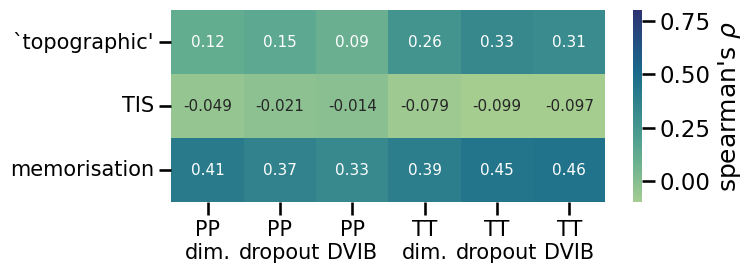

In [56]:
names = ["PP\ndim.", "PP\ndropout", "PP\nDVIB", "TT\ndim.", "TT\ndropout", "TT\nDVIB"]

heatmap = [tps_corr, tree_impurity_corr, empirical_memorisation_corr]

plt.figure(figsize=(7, 2.5))
ax = sns.heatmap(heatmap, cmap="crest",
            cbar_kws={"label": r"spearman's $\rho$"},
            vmin=-0.1, vmax=0.8, annot=True, annot_kws={"fontsize": 11})
ax.set_xticklabels(names, rotation=0, fontsize=15)
ax.set_yticklabels(["`topographic'", "TIS", "memorisation"], rotation=0, fontsize=15)
plt.savefig("figures/correlation_rankings_baselines.pdf", bbox_inches="tight")

### 5. Compare the different rankings to each other

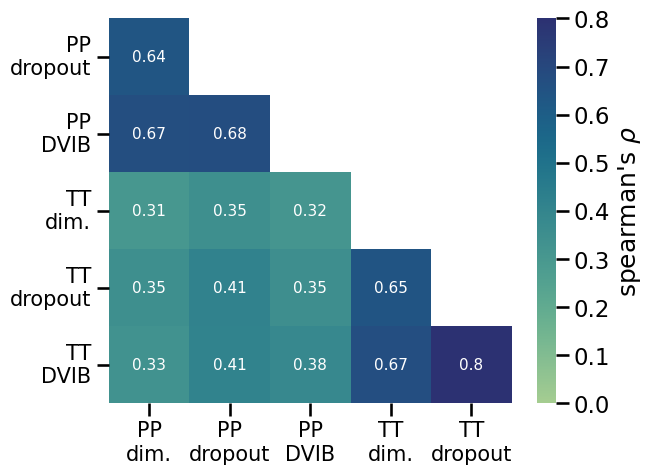

In [57]:
matrix = np.zeros((6, 6))

for i, x in enumerate(rankings):
    for j, y in enumerate(rankings):
        r = rate(x[0], y[0])
        matrix[i, j] = r

plt.figure(figsize=(6.5, 5))
ax = sns.heatmap(matrix, cmap="crest", mask=np.triu(matrix),
                 cbar_kws={"label": r"spearman's $\rho$"}, annot=True,
                 vmin=0, vmax=0.8, annot_kws={"fontsize": 11})
plt.xlim(0, 5)
plt.ylim(6, 1)
ax.set_xticklabels(names, rotation=0, fontsize=15)
ax.set_yticklabels(names, rotation=0, fontsize=15)
plt.savefig("figures/correlations_across_rankings.pdf", bbox_inches="tight")